# ML HW2 sample code
TODO:
 - Design your CNN model (you are welcomed to use existing models)
 - Hyperparameter tuning
 - Confusion matrix

Report:
 - Structure of CNN model
 - Data Augmentation
 - Draw the confusion matrix

#### Download data


In [8]:
!gdown 19oEShkdcBJf41nu46anyvu7BgXUffIGi
!unzip -q 'HW2.zip'

Downloading...
From (original): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi
From (redirected): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi&confirm=t&uuid=a3f188f6-4dd3-4055-b566-db3d6bc873e3
To: /content/HW2.zip
100% 52.1M/52.1M [00:01<00:00, 44.5MB/s]


#### Import packages

In [9]:
import os
import random
import csv
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from torchsummary import summary
import torchvision.transforms as T
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from argparse import Namespace
from tqdm import tqdm

#### Hyperparameters and setting

In [10]:
# TODO: modify the hyperparameters
config = Namespace(
    random_seed = 42,
    BATCH = 128,
    n_epoch = 10,
    lr = 1e-4,
    weight_decay = 1e-7,
    ckpt_path = 'model.pth',
)

In [11]:
TRA_PATH = 'data/train/'
TST_PATH = 'data/test/'
LABEL_PATH = 'data/train.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(config.random_seed)
torch.cuda.manual_seed_all(config.random_seed)
random.seed(config.random_seed)
np.random.seed(config.random_seed)

#### Dataset and Dataloader

In [12]:
class FaceExpressionDataset(Dataset):
    def __init__(self, img_path, label_path=None, tfm=T.ToTensor()):
        n_samples = len(os.listdir(img_path))
        if label_path is not None:
            self.images = [f'{img_path}/{i+7000}.jpg' for i in range(n_samples)]
            self.labels = pd.read_csv(label_path)['label'].values.tolist()
        else:
            self.images = [f'{img_path}/{i}.jpg' for i in range(n_samples)]
            self.labels = None
        self.tfm = tfm

    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        img = self.tfm(img)
        if self.labels is not None:
            lab = torch.tensor(self.labels[idx]).long()
            return img, lab
        else:
            return img

    def __len__(self):
        return len(self.images)

In [13]:
# TODO: define your augmentation for training and evaluation
train_tfm = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    # T.Normalize(mean=[0.485], std=[0.229]),
])
eval_tfm = T.Compose([
    T.ToTensor(),
    # T.Normalize(mean=[0.485], std=[0.229])
])

In [14]:
# dataset
train_dataset = FaceExpressionDataset(TRA_PATH, LABEL_PATH, tfm=train_tfm)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
test_dataset = FaceExpressionDataset(TST_PATH, tfm=eval_tfm)
# dataloader
train_loader = DataLoader(train_dataset, batch_size=config.BATCH, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH, shuffle=False)

#### Model

In [15]:
# TODO: define your CNN model
class FaceExpressionNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
          nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
          nn.Linear(64 * 8 * 8, 256),
          nn.ReLU(),
          nn.Linear(256, 7)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.fc(x)
        return x

#### training loop

In [16]:
def train(model, train_loader, valid_loader, config):
    model.to(device)
    criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    best_acc = 0
    train_losses, valid_losses = [], []
    for epoch in range(config.n_epoch):
        # train
        model.train()
        train_loss, train_acc = 0, 0
        for img, lab in tqdm(train_loader):
            img, lab = img.to(device), lab.to(device)
            output = model(img)
            optimizer.zero_grad()
            loss = criteria(output, lab)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        train_loss, train_acc = train_loss/len(train_loader), train_acc/len(train_loader)
        train_losses.append(train_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')

        # valid
        model.eval()
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            for img, lab in valid_loader:
                img, lab = img.to(device), lab.to(device)
                output = model(img)
                loss = criteria(output, lab)
                valid_loss += loss.item()
                valid_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        valid_loss, valid_acc = valid_loss/len(valid_loader), valid_acc/len(valid_loader)
        valid_losses.append(valid_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, valid loss: {valid_loss:.4f}, valid acc: {valid_acc:.4f}')

        # update
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), config.ckpt_path)
            print(f'== best valid acc: {best_acc:.4f} ==')
    model.load_state_dict(torch.load(config.ckpt_path))

    # plot the training/validation loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(config.n_epoch), train_losses, label='Training Loss')
    plt.plot(range(config.n_epoch), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Training

100%|██████████| 181/181 [00:14<00:00, 12.32it/s]


Epoch: 1/10, train loss: 1.7946, train acc: 0.2589
Epoch: 1/10, valid loss: 1.7647, valid acc: 0.2840
== best valid acc: 0.2840 ==


100%|██████████| 181/181 [00:13<00:00, 13.49it/s]


Epoch: 2/10, train loss: 1.7222, train acc: 0.3097
Epoch: 2/10, valid loss: 1.6821, valid acc: 0.3354
== best valid acc: 0.3354 ==


100%|██████████| 181/181 [00:12<00:00, 14.00it/s]


Epoch: 3/10, train loss: 1.6523, train acc: 0.3567
Epoch: 3/10, valid loss: 1.6310, valid acc: 0.3744
== best valid acc: 0.3744 ==


100%|██████████| 181/181 [00:12<00:00, 13.98it/s]


Epoch: 4/10, train loss: 1.6184, train acc: 0.3785
Epoch: 4/10, valid loss: 1.6226, valid acc: 0.3634


100%|██████████| 181/181 [00:12<00:00, 13.96it/s]


Epoch: 5/10, train loss: 1.6008, train acc: 0.3838
Epoch: 5/10, valid loss: 1.5910, valid acc: 0.3932
== best valid acc: 0.3932 ==


100%|██████████| 181/181 [00:13<00:00, 13.76it/s]


Epoch: 6/10, train loss: 1.5846, train acc: 0.3907
Epoch: 6/10, valid loss: 1.5797, valid acc: 0.3930


100%|██████████| 181/181 [00:13<00:00, 13.56it/s]


Epoch: 7/10, train loss: 1.5777, train acc: 0.3963
Epoch: 7/10, valid loss: 1.5761, valid acc: 0.3973
== best valid acc: 0.3973 ==


100%|██████████| 181/181 [00:13<00:00, 13.71it/s]


Epoch: 8/10, train loss: 1.5675, train acc: 0.3979
Epoch: 8/10, valid loss: 1.5662, valid acc: 0.3955


100%|██████████| 181/181 [00:13<00:00, 13.59it/s]


Epoch: 9/10, train loss: 1.5604, train acc: 0.4015
Epoch: 9/10, valid loss: 1.5927, valid acc: 0.3880


100%|██████████| 181/181 [00:12<00:00, 13.99it/s]


Epoch: 10/10, train loss: 1.5505, train acc: 0.4047
Epoch: 10/10, valid loss: 1.5524, valid acc: 0.4052
== best valid acc: 0.4052 ==


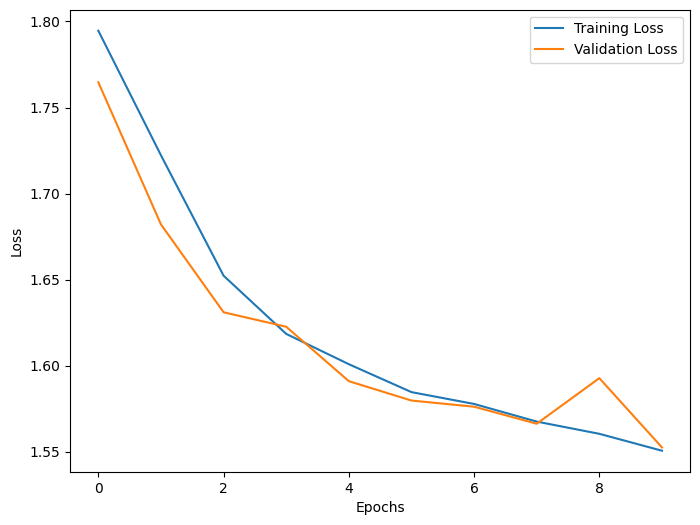

In [17]:
model = FaceExpressionNet()
summary(model, (1, 64, 64))
train(model, train_loader, valid_loader, config)

In [18]:
def draw_confusion_matrix(model, valid_loader):
    predictions, labels = [], []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img, lab in tqdm(valid_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
            labels += lab.tolist()
    # TODO draw the confusion matrix

draw_confusion_matrix(model, valid_loader)


100%|██████████| 46/46 [00:02<00:00, 17.29it/s]


### Testing

In [19]:
def test(model, test_loader):
    predictions = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img in tqdm(test_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
    with open('predict.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for id, r in enumerate(predictions):
            writer.writerow([id, r])

In [20]:
model.load_state_dict(torch.load('model.pth'))
test(model, test_loader)

100%|██████████| 55/55 [00:02<00:00, 23.21it/s]
